In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import nolds
from MHP import MHP
import inspect
import datetime

# Import sample data

Using S&P 500 data from Nov-2014 to Nov-2019. Will just use opening price to make life easy

[Source: Yahoo Finance](https://finance.yahoo.com/quote/%5EGSPC/history?period1=1415145600&period2=1572912000&interval=1d&filter=history&frequency=1d)

In [2]:
s_and_p_data = pd.read_csv('S&P5yrSample.csv', usecols = ['Date','Open'])

In [3]:
s_and_p_data['Date'] = pd.to_datetime(s_and_p_data['Date'])

In [4]:
s_and_p_data.head(5)

,Date,Open
0,2014-11-05,2015.290039
1,2014-11-06,2023.329956
2,2014-11-07,2032.359985
3,2014-11-10,2032.010010
4,2014-11-11,2038.199951


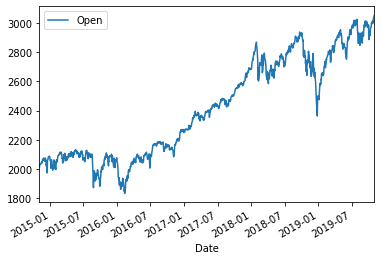

In [5]:
s_and_p_data.plot(x = 'Date', y = 'Open')

# Hawkes process

In [6]:
from MHP import MHP
import numpy as np
P = MHP()
P.generate_seq(60)

Max eigenvalue: 0.50000


array([[8.078999686280422, array([0])],
       [8.275780293362901, array([0])],
       [8.788281489687122, array([0])],
       [9.303139696291543, array([0])],
       [9.9986941162083, array([0])],
       [10.4565274837273, array([0])],
       [10.684760158354921, array([0])],
       [10.7152223916021, array([0])],
       [10.738633532435477, array([0])],
       [15.671305890986254, array([0])],
       [15.728173449709823, array([0])],
       [17.41231161377269, array([0])],
       [18.17286356628765, array([0])],
       [36.148659556990445, array([0])],
       [45.72325034747418, array([0])],
       [46.18279530385148, array([0])]], dtype=object)

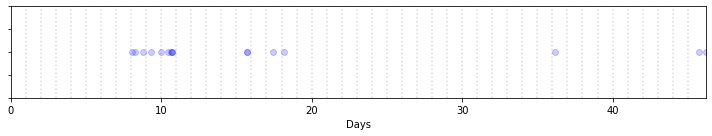

In [7]:
P.plot_events()

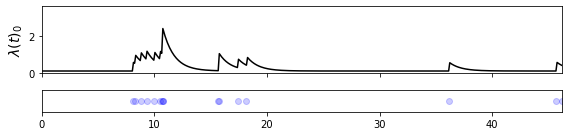

In [8]:
P.plot_rates()

# Lyapunov exponent

## Based on Rosenstein

### Put data into phase space

In [61]:
def gen_phase_space_vector(row, J = 1, m = 10):
    i = row.name
    
    x_i = [] 

    for it in range(0, m):
        i_plus_j = i + J*it
        try:
            x_i.append((s_and_p_data.loc[s_and_p_data.index == i_plus_j]['Open'].item()))
        except:
            x_i.append(np.nan)
    return x_i

In [63]:
test_df = s_and_p_data.apply(gen_phase_space_vector, axis = 1, result_type = 'expand')

/Users/calumthompson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: `item` has been deprecated and will be removed in a future version
  if __name__ == '__main__':


In [64]:
test_df.head(10)

,0,1,2,3,4,5,6,7,8,9
0,2015.290039,2023.329956,2032.359985,2032.010010,2038.199951,2037.750000,2039.209961,2039.739990,2038.290039,2041.479980
1,2023.329956,2032.359985,2032.010010,2038.199951,2037.750000,2039.209961,2039.739990,2038.290039,2041.479980,2051.159912
2,2032.359985,2032.010010,2038.199951,2037.750000,2039.209961,2039.739990,2038.290039,2041.479980,2051.159912,2045.869995
3,2032.010010,2038.199951,2037.750000,2039.209961,2039.739990,2038.290039,2041.479980,2051.159912,2045.869995,2057.459961
4,2038.199951,2037.750000,2039.209961,2039.739990,2038.290039,2041.479980,2051.159912,2045.869995,2057.459961,2065.070068
5,2037.750000,2039.209961,2039.739990,2038.290039,2041.479980,2051.159912,2045.869995,2057.459961,2065.070068,2070.149902
6,2039.209961,2039.739990,2038.290039,2041.479980,2051.159912,2045.869995,2057.459961,2065.070068,2070.149902,2067.360107
7,2039.739990,2038.290039,2041.479980,2051.159912,2045.869995,2057.459961,2065.070068,2070.149902,2067.360107,2074.780029
8,2038.290039,2041.479980,2051.159912,2045.869995,2057.459961,2065.070068,2070.149902,2067.360107,2074.780029,2065.780029
9,2041.479980,2051.159912,2045.869995,2057.459961,2065.070068,2070.149902,2067.360107,2074.780029,2065.780029,2053.770020


### Find distance to nearest neighbours

In [96]:
def find_nearest_neighbour(row):
    
    inital_value = row[0]

    results = pd.DataFrame(row)
    
    results['difference_to_NN'] = results.apply(lambda x:  np.abs(inital_value - x))
        
    print(results)

In [97]:
test_df.head(1).apply(find_nearest_neighbour, axis = 1)

             0  difference_to_NN
0  2015.290039          0.000000
1  2023.329956          8.039917
2  2032.359985         17.069946
3  2032.010010         16.719971
4  2038.199951         22.909912
5  2037.750000         22.459961
6  2039.209961         23.919922
7  2039.739990         24.449951
8  2038.290039         23.000000
9  2041.479980         26.189941


0    None
dtype: object

## Nolds


In [15]:
print(inspect.getsource(nolds.lyap_r))

def lyap_r(data, emb_dim=10, lag=None, min_tsep=None, tau=1, min_neighbors=20,
           trajectory_len=20, fit="RANSAC", debug_plot=False, debug_data=False,
           plot_file=None, fit_offset=0):
  """
  Estimates the largest Lyapunov exponent using the algorithm of Rosenstein
  et al. [lr_1]_.

  Explanation of Lyapunov exponents:
    See lyap_e.

  Explanation of the algorithm:
    The algorithm of Rosenstein et al. is only able to recover the largest
    Lyapunov exponent, but behaves rather robust to parameter choices.

    The idea for the algorithm relates closely to the definition of Lyapunov
    exponents. First, the dynamics of the data are reconstructed using a delay
    embedding method with a lag, such that each value x_i of the data is mapped
    to the vector

    X_i = [x_i, x_(i+lag), x_(i+2*lag), ..., x_(i+(emb_dim-1) * lag)]

    For each such vector X_i, we find the closest neighbor X_j using the
    euclidean distance. We know that as we follow the trajectories

In [16]:
def lyap_r(data, emb_dim=10, lag=None, min_tsep=None, tau=1, min_neighbors=20,
           trajectory_len=20, fit="RANSAC", debug_plot=False, debug_data=False,
           plot_file=None, fit_offset=0):
  """
  Estimates the largest Lyapunov exponent using the algorithm of Rosenstein
  et al. [lr_1]_.

  Explanation of Lyapunov exponents:
    See lyap_e.

  Explanation of the algorithm:
    The algorithm of Rosenstein et al. is only able to recover the largest
    Lyapunov exponent, but behaves rather robust to parameter choices.

    The idea for the algorithm relates closely to the definition of Lyapunov
    exponents. First, the dynamics of the data are reconstructed using a delay
    embedding method with a lag, such that each value x_i of the data is mapped
    to the vector

    X_i = [x_i, x_(i+lag), x_(i+2*lag), ..., x_(i+(emb_dim-1) * lag)]

    For each such vector X_i, we find the closest neighbor X_j using the
    euclidean distance. We know that as we follow the trajectories from X_i and
    X_j in time in a chaotic system the distances between X_(i+k) and X_(j+k)
    denoted as d_i(k) will increase according to a power law
    d_i(k) = c * e^(lambda * k) where lambda is a good approximation of the
    highest Lyapunov exponent, because the exponential expansion along the axis
    associated with this exponent will quickly dominate the expansion or
    contraction along other axes.

    To calculate lambda, we look at the logarithm of the distance trajectory,
    because log(d_i(k)) = log(c) + lambda * k. This gives a set of lines
    (one for each index i) whose slope is an approximation of lambda. We
    therefore extract the mean log trajectory d'(k) by taking the mean of
    log(d_i(k)) over all orbit vectors X_i. We then fit a straight line to
    the plot of d'(k) versus k. The slope of the line gives the desired
    parameter lambda.

  Method for choosing min_tsep:
    Usually we want to find neighbors between points that are close in phase
    space but not too close in time, because we want to avoid spurious
    correlations between the obtained trajectories that originate from temporal
    dependencies rather than the dynamic properties of the system. Therefore it
    is critical to find a good value for min_tsep. One rather plausible
    estimate for this value is to set min_tsep to the mean period of the
    signal, which can be obtained by calculating the mean frequency using the
    fast fourier transform. This procedure is used by default if the user sets
    min_tsep = None.

  Method for choosing lag:
    Another parameter that can be hard to choose by instinct alone is the lag
    between individual values in a vector of the embedded orbit. Here,
    Rosenstein et al. suggest to set the lag to the distance where the
    autocorrelation function drops below 1 - 1/e times its original (maximal)
    value. This procedure is used by default if the user sets lag = None.

  References:
    .. [lr_1] M. T. Rosenstein, J. J. Collins, and C. J. De Luca,
       “A practical method for calculating largest Lyapunov exponents from
       small data sets,” Physica D: Nonlinear Phenomena, vol. 65, no. 1,
       pp. 117–134, 1993.

  Reference Code:
    .. [lr_a] mirwais, "Largest Lyapunov Exponent with Rosenstein's Algorithm",
       url: http://www.mathworks.com/matlabcentral/fileexchange/38424-largest-lyapunov-exponent-with-rosenstein-s-algorithm
    .. [lr_b] Shapour Mohammadi, "LYAPROSEN: MATLAB function to calculate
       Lyapunov exponent",
       url: https://ideas.repec.org/c/boc/bocode/t741502.html

  Args:
    data (iterable of float):
      (one-dimensional) time series
  Kwargs:
    emb_dim (int):
      embedding dimension for delay embedding
    lag (float):
      lag for delay embedding
    min_tsep (float):
      minimal temporal separation between two "neighbors" (default:
      find a suitable value by calculating the mean period of the data)
    tau (float):
      step size between data points in the time series in seconds
      (normalization scaling factor for exponents)
    min_neighbors (int):
      if lag=None, the search for a suitable lag will be stopped when the
      number of potential neighbors for a vector drops below min_neighbors
    trajectory_len (int):
      the time (in number of data points) to follow the distance
      trajectories between two neighboring points
    fit (str):
      the fitting method to use for the line fit, either 'poly' for normal
      least squares polynomial fitting or 'RANSAC' for RANSAC-fitting which
      is more robust to outliers
    debug_plot (boolean):
      if True, a simple plot of the final line-fitting step will
      be shown
    debug_data (boolean):
      if True, debugging data will be returned alongside the result
    plot_file (str):
      if debug_plot is True and plot_file is not None, the plot will be saved
      under the given file name instead of directly showing it through
      ``plt.show()``
    fit_offset (int):
      neglect the first fit_offset steps when fitting

  Returns:
    float:
      an estimate of the largest Lyapunov exponent (a positive exponent is
      a strong indicator for chaos)
    (1d-vector, 1d-vector, list):
      only present if debug_data is True: debug data of the form
      ``(ks, div_traj, poly)`` where ``ks`` are the x-values of the line fit, 
      ``div_traj`` are the y-values and ``poly`` are the line coefficients
      (``[slope, intercept]``).

  """
  # convert data to float to avoid overflow errors in rowwise_euclidean
  data = np.asarray(data, dtype="float32")
  n = len(data)
  max_tsep_factor = 0.25
  if lag is None or min_tsep is None:
    # both the algorithm for lag and min_tsep need the fft
    f = np.fft.rfft(data, n * 2 - 1)
  if min_tsep is None:
    # calculate min_tsep as mean period (= 1 / mean frequency)
    mf = np.fft.rfftfreq(n * 2 - 1) * np.abs(f)
    mf = np.mean(mf[1:]) / np.sum(np.abs(f[1:]))
    min_tsep = int(np.ceil(1.0 / mf))
    if min_tsep > max_tsep_factor * n:
      min_tsep = int(max_tsep_factor * n)
      msg = "signal has very low mean frequency, setting min_tsep = {:d}"
      warnings.warn(msg.format(min_tsep), RuntimeWarning)
  if lag is None:
    # calculate the lag as point where the autocorrelation drops to (1 - 1/e)
    # times its maximum value
    # note: the Wiener–Khinchin theorem states that the spectral
    # decomposition of the autocorrelation function of a process is the power
    # spectrum of that process
    # => we can use fft to calculate the autocorrelation
    acorr = np.fft.irfft(f * np.conj(f))
    acorr = np.roll(acorr, n - 1)
    eps = acorr[n - 1] * (1 - 1.0 / np.e)
    lag = 1
    # small helper function to calculate resulting number of vectors for a
    # given lag value
    def nb_neighbors(lag_value):
      min_len = lyap_r_len(
        emb_dim=emb_dim, lag=i, trajectory_len=trajectory_len,
        min_tsep=min_tsep
      )
      return max(0, n - min_len)
    # find lag
    for i in range(1,n):
      lag = i
      if acorr[n - 1 + i] < eps or acorr[n - 1 - i] < eps:
        break
      if nb_neighbors(i) < min_neighbors:
        msg = "autocorrelation declined too slowly to find suitable lag" \
          + ", setting lag to {}"
        warnings.warn(msg.format(lag), RuntimeWarning)
        break
  min_len = lyap_r_len(
    emb_dim=emb_dim, lag=lag, trajectory_len=trajectory_len,
    min_tsep=min_tsep
  )
  if len(data) < min_len:
    msg = "for emb_dim = {}, lag = {}, min_tsep = {} and trajectory_len = {}" \
      + " you need at least {} datapoints in your time series"
    warnings.warn(
      msg.format(emb_dim, lag, min_tsep, trajectory_len, min_len),
      RuntimeWarning
    )
  # delay embedding
  orbit = delay_embedding(data, emb_dim, lag)
  m = len(orbit)
  # construct matrix with pairwise distances between vectors in orbit
  dists = np.array([rowwise_euclidean(orbit, orbit[i]) for i in range(m)])
  # we do not want to consider vectors as neighbor that are less than min_tsep
  # time steps together => mask the distances min_tsep to the right and left of
  # each index by setting them to infinity (will never be considered as nearest
  # neighbors)
  for i in range(m):
    dists[i, max(0, i - min_tsep):i + min_tsep + 1] = float("inf")
  # check that we have enough data points to continue
  ntraj = m - trajectory_len + 1
  min_traj = min_tsep * 2 + 2 # in each row min_tsep + 1 disances are inf
  if ntraj <= 0:
    msg = "Not enough data points. Need {} additional data points to follow " \
        + "a complete trajectory."
    raise ValueError(msg.format(-ntraj+1))
  if ntraj < min_traj:
    # not enough data points => there are rows where all values are inf
    assert np.any(np.all(np.isinf(dists[:ntraj, :ntraj]), axis=1))
    msg = "Not enough data points. At least {} trajectories are required " \
        + "to find a valid neighbor for each orbit vector with min_tsep={} " \
        + "but only {} could be created."
    raise ValueError(msg.format(min_traj, min_tsep, ntraj))
  assert np.all(np.any(np.isfinite(dists[:ntraj, :ntraj]), axis=1))
  # find nearest neighbors (exclude last columns, because these vectors cannot
  # be followed in time for trajectory_len steps)
  nb_idx = np.argmin(dists[:ntraj, :ntraj], axis=1)
  
  # build divergence trajectory by averaging distances along the trajectory
  # over all neighbor pairs
  div_traj = np.zeros(trajectory_len, dtype=float)
  for k in range(trajectory_len):
    # calculate mean trajectory distance at step k
    indices = (np.arange(ntraj) + k, nb_idx + k)
    div_traj_k = dists[indices]
    # filter entries where distance is zero (would lead to -inf after log)
    nonzero = np.where(div_traj_k != 0)
    if len(nonzero[0]) == 0:
      # if all entries where zero, we have to use -inf
      div_traj[k] = -np.inf
    else:
      div_traj[k] = np.mean(np.log(div_traj_k[nonzero]))
  # filter -inf entries from mean trajectory
  ks = np.arange(trajectory_len)
  finite = np.where(np.isfinite(div_traj))
  ks = ks[finite]
  div_traj = div_traj[finite]
  if len(ks) < 1:
    # if all points or all but one point in the trajectory is -inf, we cannot
    # fit a line through the remaining points => return -inf as exponent
    poly = [-np.inf, 0]
  else:
    # normal line fitting
    poly = poly_fit(ks[fit_offset:], div_traj[fit_offset:], 1, fit=fit)
  if debug_plot:
    plot_reg(ks[fit_offset:], div_traj[fit_offset:], poly, "k", "log(d(k))", fname=plot_file)
  le = poly[0] / tau
  if debug_data:
    return (le, (ks, div_traj, poly))
  else:
    return le

In [17]:
nolds.lyap_r(s_and_p_data)

TypeError: float() argument must be a string or a number, not 'Timestamp'